In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import unix_timestamp, hour
import matplotlib.pyplot as plt
import pandas as pd
spark = SparkSession.builder.master('local[*]').getOrCreate()

sc = spark.sparkContext

spark

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 11.6 gigabytes of available RAM



In [3]:
# Comenzar a medir el tiempo
start_time = time.time()
# Cargar los datos
df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017-01.csv")

In [19]:
df_limited_1 = df.limit(500000)
# Cantidad de datos procesados
num_viajes = df.count()
print(f"Cantidad de datos procesados: {num_viajes} viajes.")

Cantidad de datos procesados: 971010 viajes.


In [5]:
df_limited_2 = df_limited_1["tpep_pickup_datetime","tpep_dropoff_datetime","trip_distance"]

In [6]:
df_limited_2.show()

+--------------------+---------------------+-------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|
+--------------------+---------------------+-------------+
| 2017-01-09 11:13:28|  2017-01-09 11:25:45|          3.3|
| 2017-01-09 11:32:27|  2017-01-09 11:36:01|          0.9|
| 2017-01-09 11:38:20|  2017-01-09 11:42:05|          1.1|
| 2017-01-09 11:52:13|  2017-01-09 11:57:36|          1.1|
| 2017-01-01 00:00:00|  2017-01-01 00:00:00|         0.02|
| 2017-01-01 00:00:02|  2017-01-01 00:03:50|          0.5|
| 2017-01-01 00:00:02|  2017-01-01 00:39:22|         7.75|
| 2017-01-01 00:00:03|  2017-01-01 00:06:58|          0.8|
| 2017-01-01 00:00:05|  2017-01-01 00:08:33|          0.9|
| 2017-01-01 00:00:05|  2017-01-01 00:05:04|         1.76|
| 2017-01-01 00:00:05|  2017-01-01 00:15:36|         8.47|
| 2017-01-01 00:00:06|  2017-01-01 00:11:56|          2.4|
| 2017-01-01 00:00:06|  2017-01-01 00:23:37|         12.6|
| 2017-01-01 00:00:06|  2017-01-01 00:08:53|          0.

In [7]:
df_limited_2=df_limited_2.withColumn('duration',
                                   (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))/3600)

In [8]:
df_limited_2=df_limited_2.filter(df_limited_2["duration"]>0)

In [9]:
df_limited_2.show()

+--------------------+---------------------+-------------+--------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|            duration|
+--------------------+---------------------+-------------+--------------------+
| 2017-01-09 11:13:28|  2017-01-09 11:25:45|          3.3| 0.20472222222222222|
| 2017-01-09 11:32:27|  2017-01-09 11:36:01|          0.9|0.059444444444444446|
| 2017-01-09 11:38:20|  2017-01-09 11:42:05|          1.1|              0.0625|
| 2017-01-09 11:52:13|  2017-01-09 11:57:36|          1.1| 0.08972222222222222|
| 2017-01-01 00:00:02|  2017-01-01 00:03:50|          0.5| 0.06333333333333334|
| 2017-01-01 00:00:02|  2017-01-01 00:39:22|         7.75|  0.6555555555555556|
| 2017-01-01 00:00:03|  2017-01-01 00:06:58|          0.8| 0.11527777777777778|
| 2017-01-01 00:00:05|  2017-01-01 00:08:33|          0.9|  0.1411111111111111|
| 2017-01-01 00:00:05|  2017-01-01 00:05:04|         1.76| 0.08305555555555555|
| 2017-01-01 00:00:05|  2017-01-01 00:15

In [10]:
df_limited_2=df_limited_2.withColumn('velocidad', df_limited_2["trip_distance"]/df_limited_2["duration"])

In [11]:
df_limited_2=df_limited_2.withColumn('hora', hour(df["tpep_pickup_datetime"]))

In [12]:
df_limited_2.show()

+--------------------+---------------------+-------------+--------------------+------------------+----+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|            duration|         velocidad|hora|
+--------------------+---------------------+-------------+--------------------+------------------+----+
| 2017-01-09 11:13:28|  2017-01-09 11:25:45|          3.3| 0.20472222222222222|16.119402985074625|  11|
| 2017-01-09 11:32:27|  2017-01-09 11:36:01|          0.9|0.059444444444444446| 15.14018691588785|  11|
| 2017-01-09 11:38:20|  2017-01-09 11:42:05|          1.1|              0.0625|              17.6|  11|
| 2017-01-09 11:52:13|  2017-01-09 11:57:36|          1.1| 0.08972222222222222|12.260061919504645|  11|
| 2017-01-01 00:00:02|  2017-01-01 00:03:50|          0.5| 0.06333333333333334| 7.894736842105263|   0|
| 2017-01-01 00:00:02|  2017-01-01 00:39:22|         7.75|  0.6555555555555556|11.822033898305085|   0|
| 2017-01-01 00:00:03|  2017-01-01 00:06:58|          0.8| 0.115

In [13]:
df_limited_3=df_limited_2.select("velocidad","hora").groupby("hora").mean()

In [14]:
df_limited_3=df_limited_3.sort(df_limited_3["avg(hora)"].desc())

In [21]:
#Terminar de medir el tiempo
end_time = time.time()

# Calcular tiempo de ejecución y velocidad de procesamiento
tiempo_ejecucion = end_time - start_time
velocidad_procesamiento = num_viajes / tiempo_ejecucion

print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos.")
print(f"Velocidad de procesamiento: {velocidad_procesamiento:.2f} viajes por segundo.")

NameError: name 'time' is not defined

In [15]:
df_panda=df_limited_3.toPandas()

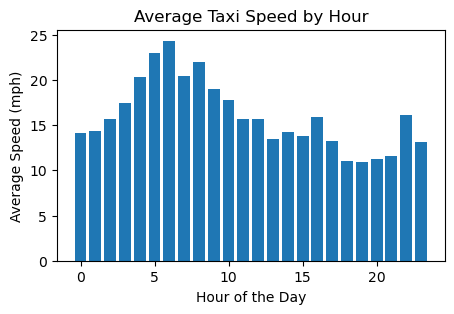

In [18]:
plt.figure(figsize=(5, 3))  # Adjusting the figure size
plt.bar(df_panda["hora"], df_panda["avg(velocidad)"])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (mph)')
plt.title('Average Taxi Speed by Hour')
plt.show()